## Importing Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA, TruncatedSVD

In [2]:
# Carregar os dados
movies_df = pd.read_csv('./Data/movies.dat', encoding='latin1', sep='::', names=['movieId', 'movie', 'genres'])
ratings_df = pd.read_csv('./Data/ratings.dat', encoding='latin1', sep='::', names=['userId','movieId', 'rating', 'timestamp'])


C:\Users\mwuillau\AppData\Local\Temp\ipykernel_38156\2317302246.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies_df = pd.read_csv('./Data/movies.dat', encoding='latin1', sep='::', names=['movieId', 'movie', 'genres'])
C:\Users\mwuillau\AppData\Local\Temp\ipykernel_38156\2317302246.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings_df = pd.read_csv('./Data/ratings.dat', encoding='latin1', sep='::', names=['userId','movieId', 'rating', 'timestamp'])


In [3]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
movies_df.head()

,movieId,movie,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


## Exploratory Analysis

### Basic Information about dataset

In [5]:

num_movies = movies_df['movieId'].nunique()
num_users = ratings_df['userId'].nunique()
num_movies_ratings = ratings_df['movieId'].nunique()
print(f"Number of movies in movie df: {num_movies}")
print(f"Number of movies in ratings df: {num_movies_ratings}")
print(f"Number of users: {num_users}")
print(f'Number of ratings:', ratings_df.shape[0])

Number of movies in movie df: 3883
Number of movies in ratings df: 3706
Number of users: 6040
Number of ratings: 1000209


- If each user had rated each movie we would have 6040*3883 = 23453320, ratings. This is not the case.
- Some films were not evaluated since the number of unique films in the film dataframe is higher than in the rating dataframe

### Distribution charts over the years

#### Number of filmes over years
<hr/>

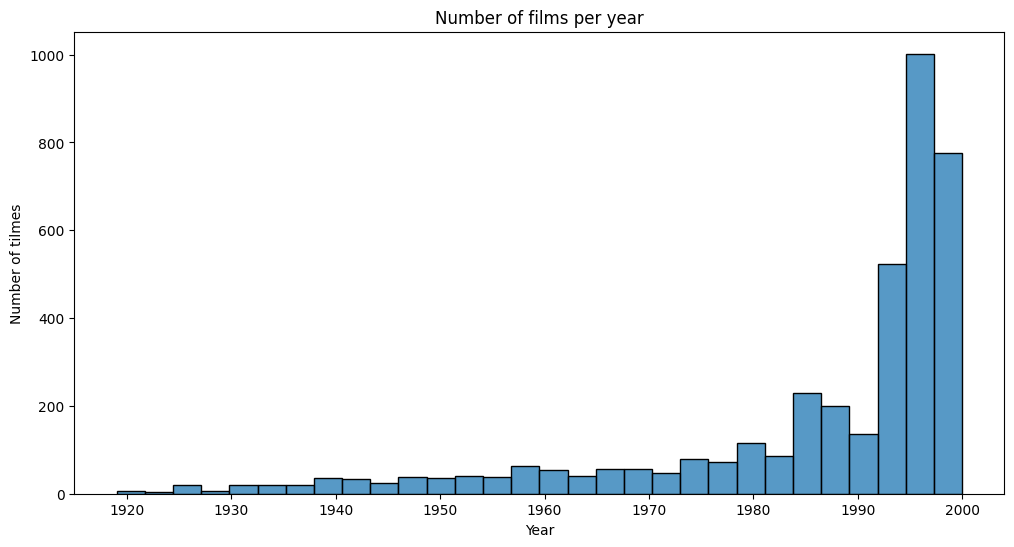

In [6]:
movies_df['year'] = movies_df['movie'].str.extract('\((\d{4})\)', expand=False)
movies_df['year'] = pd.to_numeric(movies_df['year'], errors='coerce')
plt.figure(figsize=(12, 6))
sns.histplot(data=movies_df.dropna(), x='year', bins=30)
plt.title('Number of films per year')
plt.xlabel('Year')
plt.ylabel('Number of tilmes')
plt.show()


- the films are mostly from the 90s to the 2000s

#### Distribution of genres
<hr/>

C:\Users\mwuillau\AppData\Local\Temp\ipykernel_38156\2706446228.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=movies_df['genres'].str.get_dummies('|').sum(), palette='tab10')


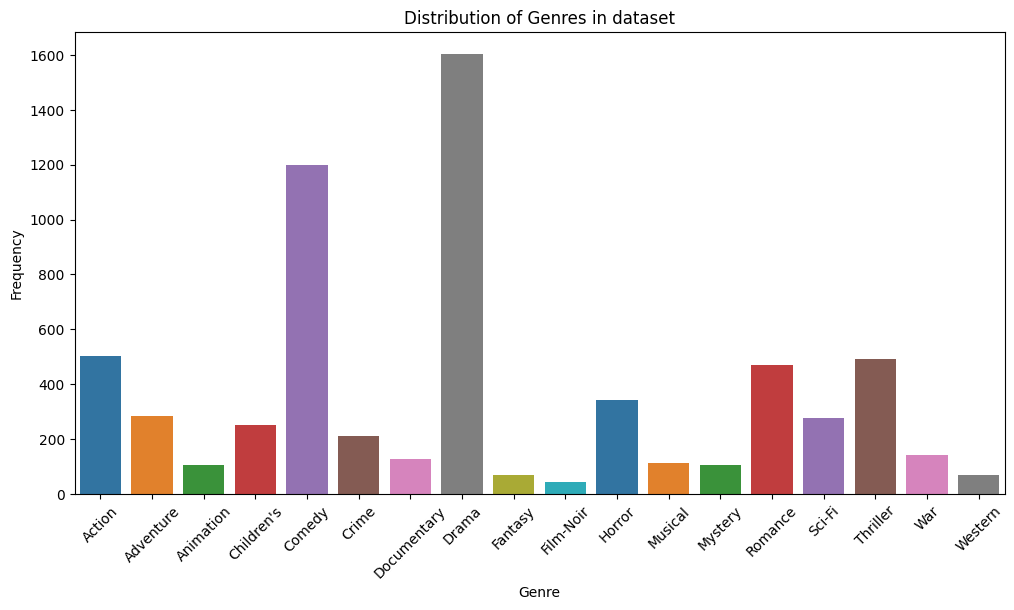

In [7]:


plt.figure(figsize=(12, 6))
sns.barplot(data=movies_df['genres'].str.get_dummies('|').sum(), palette='tab10')
plt.title('Distribution of Genres in dataset')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()




- Comedy and Drama are the distribution leaders

#### Distribution of genres over years
<hr/>

In [8]:
bins = range(movies_df['year'].min(), movies_df['year'].max() + 10, 9)
# Adicionar coluna de década
movies_df['decade'] = pd.cut(movies_df['year'], bins=bins, right=False, labels=bins[:-1]).astype(int)
last_year = movies_df.groupby('decade')['year'].max().to_dict()
fisrt_year = movies_df.groupby('decade')['year'].min().to_dict()

movies_df['decade'] = movies_df['decade'].map(lambda x: f'{fisrt_year[x]}-{last_year[x]}')


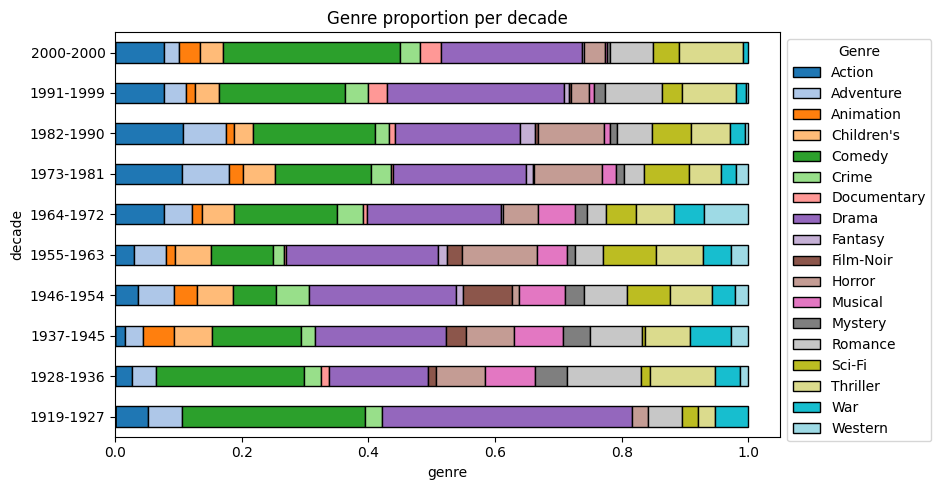

In [9]:
# Calcular a proporção de cada gênero por década
genres = movies_df['genres'].str.get_dummies('|')
genre_df = pd.concat([movies_df, genres], axis=1)

# Agrupar por década e calcular a proporção de cada gênero
genres_by_decade = genre_df.groupby('decade')[genres.columns].sum()
genres_prop = genres_by_decade.div(genres_by_decade.sum(axis=1), axis=0)

# Plotar heatmap de proporção de gêneros por década

genres_prop.plot(kind='barh', stacked=True, colormap='tab20', edgecolor='black', figsize=(8, 5))
plt.title('Genre proportion per decade')
plt.xlabel('genre')
plt.tight_layout()
plt.ylabel('decade')
plt.legend(title='Genre', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

- Some genres seem to keep it popularity, such as drama
- Some has lost its popularity over the years, such as war movies
- Comedy, on the other hand, started out famous, went downhill and came back to fame more recently
- Comedy and drama lead the proportion in almost every year

#### Distribution of ratings over years
<hr/>

In [10]:
ratings_dist = ratings_df.merge(movies_df, on='movieId')

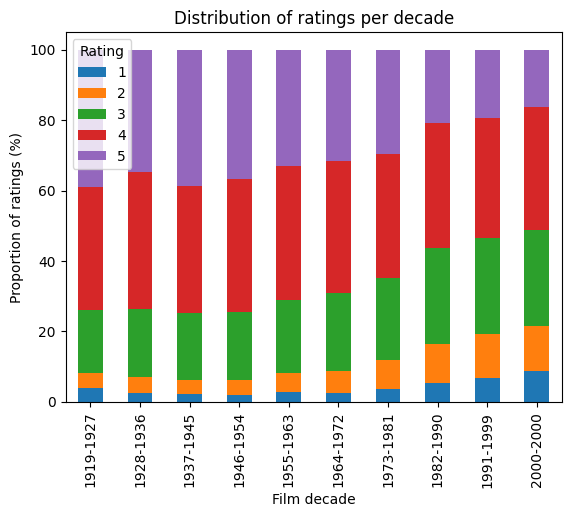

In [11]:
# Calcular a proporção de cada rating por década
rating_proportion = ratings_dist.groupby(['decade', 'rating']).size().unstack(fill_value=0)
rating_proportion = rating_proportion.div(rating_proportion.sum(axis=1), axis=0) * 100

# Plotar gráfico de barras empilhadas
rating_proportion.plot(kind='bar', stacked=True)
plt.title('Distribution of ratings per decade')
plt.xlabel('Film decade')
plt.ylabel('Proportion of ratings (%)')
plt.legend(title='Rating')
plt.show()

- the 5 grades have been reduced for newer films, grades 1, 2 and 3 have increased

## Pre-Processing

### Check for duplicate values

In [12]:
movies_df.shape, movies_df.drop_duplicates().shape

((3883, 5), (3883, 5))

In [13]:
ratings_df.shape, ratings_df.drop_duplicates().shape

((1000209, 4), (1000209, 4))

- No duplicated movies or duplicated ratings

### Generate movie x ratings matrix
- fill values with 0 when movie was not evaluated by an user

In [14]:
movie_ratings_df = movies_df.merge(ratings_df, on='movieId')

movie_ratings_matrix = pd.pivot_table(movie_ratings_df, values='rating', index='movieId', columns='userId', fill_value=0)
movie_ratings_matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
movieId,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,5.0,5.0,...,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Remove outlies

In [15]:
usuarios_constantes = movie_ratings_matrix.columns[movie_ratings_matrix.nunique() == 2]

In [16]:
usuarios_constantes.shape

(0,)

- There are no users who have given the same rating to all the films

In [17]:
# Calculando a contagem de cada nota por usuário
ratings_counts = movie_ratings_matrix.apply(lambda row: row[row != 0].value_counts().sort_values(ascending=False).iloc[0], axis=0)
num_avaliacoes_por_usuario = movie_ratings_matrix[movie_ratings_matrix != 0].count()

# Calculando a porcentagem de notas iguais para cada usuário
percent_same_rating = (ratings_counts / num_avaliacoes_por_usuario) * 100

In [18]:
movie_ratings_matrix.loc[:, percent_same_rating > 90].iloc[:, 1].value_counts()

907
0.0    3685
4.0      19
2.0       1
5.0       1
Name: count, dtype: int64

In [19]:
movie_ratings_filtered = movie_ratings_matrix.loc[:, ~(percent_same_rating > 90)]

In [20]:
movies_df_filtered = movies_df.loc[movies_df['movieId'].isin(movie_ratings_filtered.index)]

- Some users give practically (90% of the time) the same score for all movies, let's remove it from the dataset

### Normalize matrix
- Using Stardard Scaler

In [21]:

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the ratings matrix
normalized_ratings = scaler.fit_transform(movie_ratings_filtered)

# Convert the normalized array back to DataFrame
normalized_df = pd.DataFrame(normalized_ratings, index=movie_ratings_filtered.index, columns=movie_ratings_filtered.columns)


normalized_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
movieId,,,,,,,,,,,,,,,,,,,,,
1,9.805331,-0.183178,-0.114552,-0.073206,-0.222881,7.177825,-0.090532,5.075311,7.671591,3.483641,...,-0.110018,5.517974,-0.124926,-0.073641,4.724672,-0.528970,-0.233352,-0.070855,-0.181994,2.441071
2,-0.118898,-0.183178,-0.114552,-0.073206,-0.222881,-0.136678,-0.090532,-0.191870,-0.167528,3.483641,...,-0.110018,-0.164842,-0.124926,-0.073641,-0.245067,-0.528970,-0.233352,-0.070855,-0.181994,-0.300880
3,-0.118898,-0.183178,-0.114552,-0.073206,-0.222881,-0.136678,-0.090532,-0.191870,-0.167528,-0.340522,...,-0.110018,-0.164842,-0.124926,-0.073641,0.997367,-0.528970,-0.233352,-0.070855,-0.181994,-0.300880
4,-0.118898,-0.183178,-0.114552,-0.073206,-0.222881,-0.136678,-0.090532,3.758516,-0.167528,-0.340522,...,-0.110018,-0.164842,-0.124926,-0.073641,2.239802,0.807793,-0.233352,-0.070855,-0.181994,-0.300880
5,-0.118898,-0.183178,-0.114552,-0.073206,-0.222881,-0.136678,-0.090532,-0.191870,-0.167528,-0.340522,...,-0.110018,-0.164842,-0.124926,-0.073641,0.997367,-0.528970,-0.233352,-0.070855,-0.181994,-0.300880


### Calculate distance matrix

In [22]:
from sklearn.metrics import pairwise_distances
matriz_distancias_cosine = pairwise_distances(normalized_df.values, metric='cosine', n_jobs=-1)


In [23]:
# Converter a matriz de distâncias para um DataFrame do Pandas
df_distancias_cosine = pd.DataFrame(matriz_distancias_cosine, index=normalized_df.index, columns=normalized_df.index)


## Clustering without dimensionality reducion

### DBSCAN
<hr/>

In [ ]:
for i in [0.01, 0.5, 0.6, 0.65, 0.6]:
    print('Cluster distribution for eps:', i)
    dbscan = DBSCAN(eps=i, min_samples=5, metric='precomputed')
    clusters = dbscan.fit_predict(df_distancias_cosine)
    dist = pd.Series(clusters)
    dist.name = 'Distribution'
    print(dist.value_counts())


Cluster distribution for eps: 0.01
Distribution
-1    3626
 0      80
Name: count, dtype: int64
Cluster distribution for eps: 0.5
Distribution
-1    2392
 0    1286
 1      14
 2       9
 3       5
Name: count, dtype: int64
Cluster distribution for eps: 0.6
Distribution
-1    1935
 1    1598
 0     140
 3       9
 2       8
 4       6
 5       5
 6       5
Name: count, dtype: int64
Cluster distribution for eps: 0.65
Distribution
 0    2111
-1    1578
 1       6
 3       6
 2       5
Name: count, dtype: int64
Cluster distribution for eps: 0.6
Distribution
-1    1935
 1    1598
 0     140
 3       9
 2       8
 4       6
 5       5
 6       5
Name: count, dtype: int64


- The eps value of 0.65 produced a distribution of clusters that may be more interesting to analyze

### Hieralchical Clustering
<hr/>

In [25]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage
condensed_distance_matrix = squareform(np.round(df_distancias_cosine, 5))

# Perform hierarchical clustering using linkage
Z = linkage(condensed_distance_matrix, method='ward')

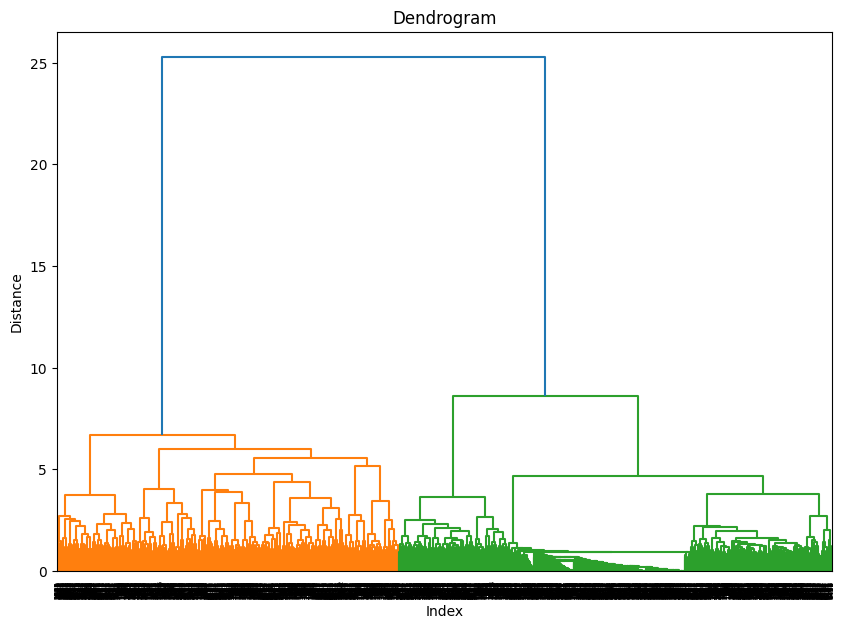

In [26]:

# Plot the dendrogram
plt.figure(figsize=(10, 7))
plt.title("Dendrogram")
dendrogram(Z)
plt.xlabel("Index")
plt.ylabel("Distance")
plt.show()

- The dendrogram clearly shows two main branches: one in orange and the other in green. This suggests that a natural division of the data is into two main clusters. But I think that two clusters cannot capture the complexity of the movies

### Kmeans
<hr/>

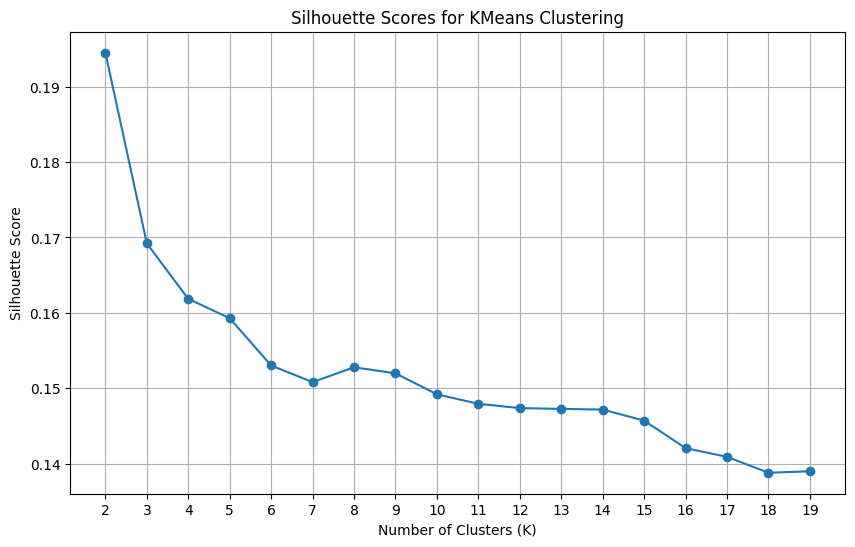

In [27]:
# Lista para armazenar as pontuações de silhueta
silhouette_scores = []
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# Testar valores de K de 2 até 15
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(normalized_df)
    
    # Calcular a pontuação de silhueta
    silhouette_avg = silhouette_score(df_distancias_cosine, cluster_labels, metric="precomputed")
    silhouette_scores.append(silhouette_avg)

# Plotar as pontuações de silhueta para cada valor de K
plt.figure(figsize=(10, 6))
plt.plot(range(2, 20), silhouette_scores, marker='o')
plt.title('Silhouette Scores for KMeans Clustering')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 20))
plt.grid(True)
plt.show()

In [28]:
kmeans = KMeans(n_clusters=5, random_state=42) 
cluster_labels = kmeans.fit_predict(normalized_df)

In [29]:
pd.Series(cluster_labels).value_counts()

0    3168
1     492
2      40
3       4
4       2
Name: count, dtype: int64

- The silhouette metric in kmeans also indicates using 2 clusters, which I don't think is ideal for analyzing the films in this dataset

- Looking at another relatively high silhouette point, k = 5, we see a distribution of films that is still very concentrated at zero

## Clustering with dimensionality reducion

### PCA
<hr/>

In [30]:
pca = PCA()
pca.fit(normalized_df)


# Calcular a variância acumulada
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Encontrar o número de componentes que explicam pelo menos 80% da variabilidade
n_components_80 = np.argmax(cumulative_variance >= 0.80) + 1

print(f"Number of components explaining at least 80% of variability: {n_components_80}")

# Reduzir os dados para o número de componentes selecionados
pca = PCA(n_components=n_components_80)
reduced_df = pca.fit_transform(normalized_df)

Number of components explaining at least 80% of variability: 597


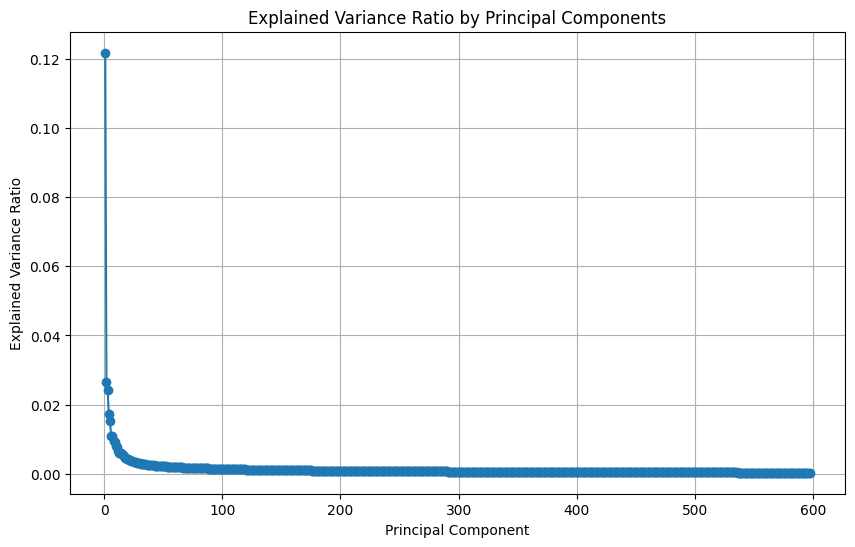

In [31]:


# Variância explicada por cada componente
explained_variance_ratio = pca.explained_variance_ratio_

# Plotar a variabilidade explicada por cada componente
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.title('Explained Variance Ratio by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()


- The news is good because we managed to reduce the dimension of the data from 6400 variables to 597, preserving 80% of the variability of the variables

### SVD
<hr/>

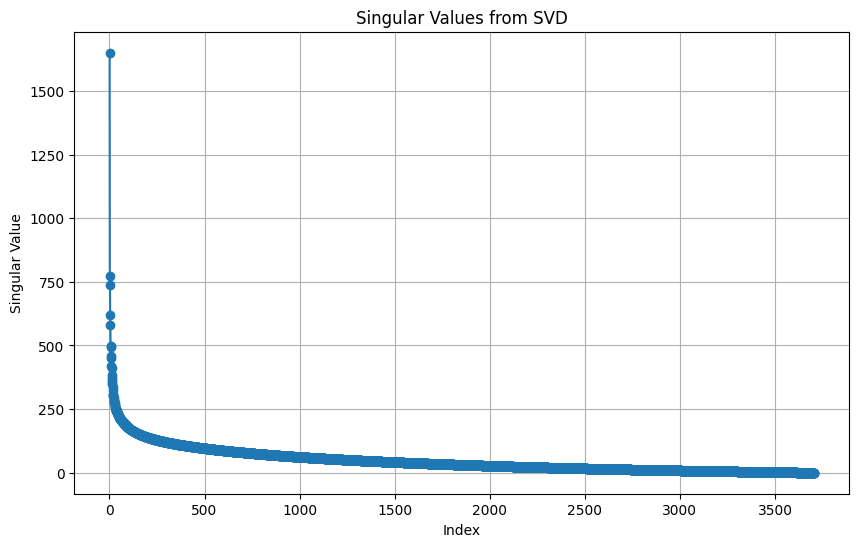

In [32]:
from sklearn.utils.extmath import randomized_svd

U, Sigma, VT = randomized_svd(np.array(normalized_df), n_components=normalized_df.shape[1])

# Plotar os valores da matriz diagonal de decomposição SVD
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(Sigma) + 1), Sigma, marker='o')
plt.title('Singular Values from SVD')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.grid(True)
plt.show()

-  The graph shows that the singular values decay rapidly, meaning that the first few dimensions capture most of the variability in the data. After a certain point, the singular values become very small, indicating that the remaining dimensions contribute very little to the total variability.

### DBScan
<hr/>

In [43]:
for i in [0.01, 0.05, 0.3, 0.4, 0.6, 0.65, 0.6]:
    print('Cluster distribution for eps:', i)
    dbscan = DBSCAN(eps=i, min_samples=5)
    clusters = dbscan.fit_predict(reduced_df)
    dist = pd.Series(clusters)
    dist.name = 'Distribution'
    print(dist.value_counts())


Cluster distribution for eps: 0.01
Distribution
-1    3688
 1      13
 0       5
Name: count, dtype: int64
Cluster distribution for eps: 0.05
Distribution
-1    3688
 1      13
 0       5
Name: count, dtype: int64
Cluster distribution for eps: 0.3
Distribution
-1    3656
 0      50
Name: count, dtype: int64
Cluster distribution for eps: 0.4
Distribution
-1    3648
 0      58
Name: count, dtype: int64
Cluster distribution for eps: 0.6
Distribution
-1    3633
 0      73
Name: count, dtype: int64
Cluster distribution for eps: 0.65
Distribution
-1    3625
 0      81
Name: count, dtype: int64
Cluster distribution for eps: 0.6
Distribution
-1    3633
 0      73
Name: count, dtype: int64


- These DBSCAN tests with the reduced dimensions produced many outliers and few clusters to analyze

### Hieralchical Clustering

C:\Users\mwuillau\AppData\Local\Temp\ipykernel_38156\2472779393.py:4: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='ward')


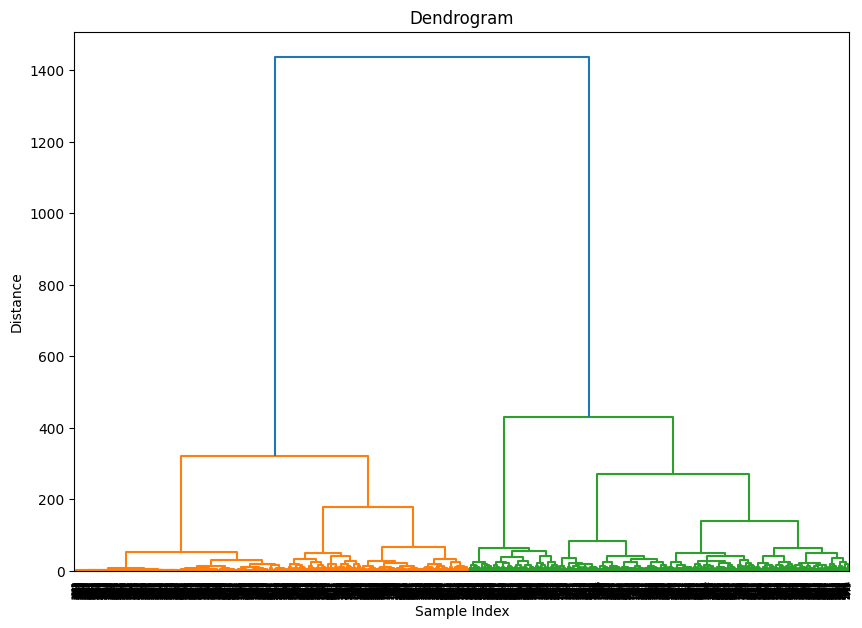

In [46]:
distance_matrix = pairwise_distances(reduced_df, metric='cosine')

# Perform hierarchical clustering using the linkage method
Z = linkage(distance_matrix, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
plt.title("Dendrogram")
dendrogram(Z)
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

- Even with reduced dimensions, dedogram suggests 2 main clusters

### Kmeans

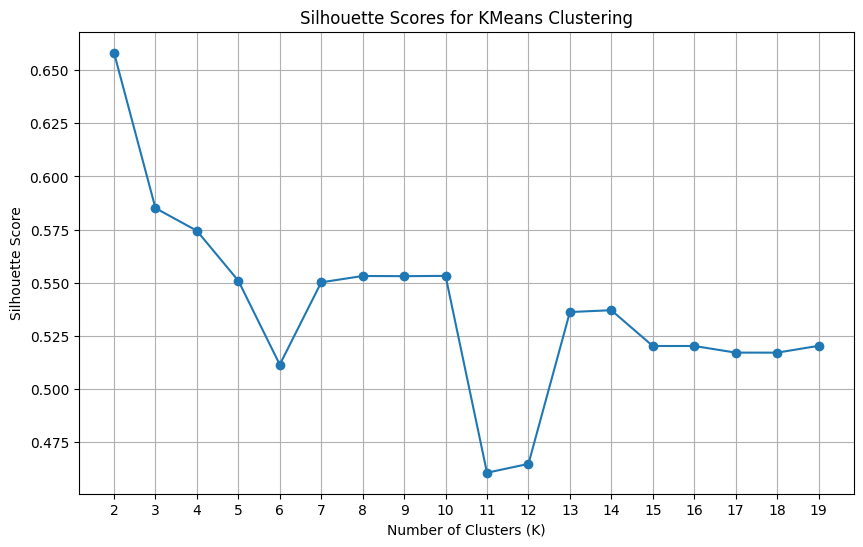

In [48]:
silhouette_scores = []
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# Testar valores de K de 2 até 15
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(reduced_df)
    
    # Calcular a pontuação de silhueta
    silhouette_avg = silhouette_score(reduced_df, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plotar as pontuações de silhueta para cada valor de K
plt.figure(figsize=(10, 6))
plt.plot(range(2, 20), silhouette_scores, marker='o')
plt.title('Silhouette Scores for KMeans Clustering')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 20))
plt.grid(True)
plt.show()

In [112]:
kmeans = KMeans(n_clusters=13, random_state=42) 
cluster_labels = kmeans.fit_predict(reduced_df)
pd.Series(cluster_labels).value_counts()

0     3089
12     282
1      188
5       61
2       39
10      19
6       11
11       5
4        3
3        3
8        2
7        2
9        2
Name: count, dtype: int64

- 2 clusters have the highest silhouette, but lets check 13 clusters as the silhouette is relative big and we can produce a lot of different groups

In [113]:
movies_df_filtered['cluster'] = cluster_labels

genres_dummies = pd.concat([movies_df_filtered['genres'].str.get_dummies('|'), movies_df_filtered['cluster']], axis=1)



C:\Users\mwuillau\AppData\Local\Temp\ipykernel_38156\2038471766.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df_filtered['cluster'] = cluster_labels


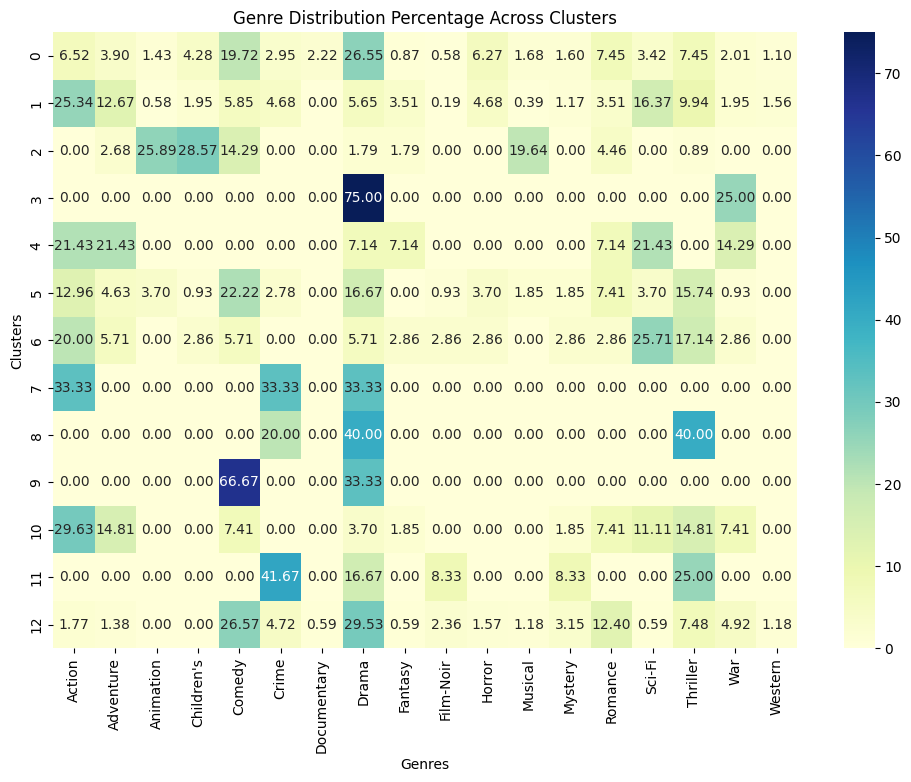

In [114]:
genre_distribution = genres_dummies.groupby('cluster').sum()
# Calcular a proporção de cada gênero dentro de cada cluster
genre_distribution_percentage = genre_distribution.div(genre_distribution.sum(axis=1), axis=0) * 100

# Plotar a distribuição dos gêneros em cada cluster em forma de proporção
plt.figure(figsize=(12, 8))
sns.heatmap(genre_distribution_percentage, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Genre Distribution Percentage Across Clusters')
plt.xlabel('Genres')
plt.ylabel('Clusters')
plt.show()

- Cluster 0 is the famous everything cluster
- Cluster 1 has a wide distribution of adventure, action and thriller genres
- Cluster 12 is distributed among the most predominant genres in the dataset, but differs from cluster zero by the greater presence of novels
- Cluster 5 also has great drama and comedy value, but the thriller and action make it stand out from cluster 0

#### Small clusters Description

clusters: 11, 9, 7, 8, 4


In [122]:
movies_df_filtered[movies_df_filtered['cluster']== 11] 

,movieId,movie,genres,year,decade,cluster
49,50,"Usual Suspects, The (1995)",Crime|Thriller,1995,1991-1999,11
293,296,Pulp Fiction (1994),Crime|Drama,1994,1991-1999,11
1073,1089,Reservoir Dogs (1992),Crime|Thriller,1992,1991-1999,11
1195,1213,GoodFellas (1990),Crime|Drama,1990,1982-1990,11
1575,1617,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller,1997,1991-1999,11


In [115]:
movies_df_filtered[movies_df_filtered['cluster']== 9] 

,movieId,movie,genres,year,decade,cluster
2789,2858,American Beauty (1999),Comedy|Drama,1999,1991-1999,9
2928,2997,Being John Malkovich (1999),Comedy,1999,1991-1999,9


In [116]:
movies_df_filtered[movies_df_filtered['cluster']== 7] 

,movieId,movie,genres,year,decade,cluster
847,858,"Godfather, The (1972)",Action|Crime|Drama,1972,1964-1972,7
1203,1221,"Godfather: Part II, The (1974)",Action|Crime|Drama,1974,1973-1981,7


In [118]:
movies_df_filtered[movies_df_filtered['cluster']== 8] 

,movieId,movie,genres,year,decade,cluster
589,593,"Silence of the Lambs, The (1991)",Drama|Thriller,1991,1991-1999,8
604,608,Fargo (1996),Crime|Drama|Thriller,1996,1991-1999,8


In [120]:
movies_df_filtered[movies_df_filtered['cluster']== 4] 

,movieId,movie,genres,year,decade,cluster
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,1977,1973-1981,4
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,1980,1973-1981,4
1192,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War,1983,1982-1990,4


In [121]:
movies_df_filtered[movies_df_filtered['cluster']== 3] 

,movieId,movie,genres,year,decade,cluster
315,318,"Shawshank Redemption, The (1994)",Drama,1994,1991-1999,3
523,527,Schindler's List (1993),Drama|War,1993,1991-1999,3
1656,1704,Good Will Hunting (1997),Drama,1997,1991-1999,3


- I found it very interesting that the first star wars films were isolated in cluster 4, as were the Godfather films in cluster 7. These films must have a very clear fanbase within the dataset
- This suggest the same about the movies in clusters 3, 9 and 11. Although the similarities between these films are not so clear-cut

#### Medium-sized clusters Description
clusters: 2, 6, 10

In [129]:
movies_df_filtered[movies_df_filtered['cluster']== 2].head(20)

,movieId,movie,genres,year,decade,cluster
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,1991-1999,2
33,34,Babe (1995),Children's|Comedy|Drama,1995,1991-1999,2
360,364,"Lion King, The (1994)",Animation|Children's|Musical,1994,1991-1999,2
547,551,"Nightmare Before Christmas, The (1993)",Children's|Comedy|Musical,1993,1991-1999,2
584,588,Aladdin (1992),Animation|Children's|Comedy|Musical,1992,1991-1999,2
590,594,Snow White and the Seven Dwarfs (1937),Animation|Children's|Musical,1937,1937-1945,2
591,595,Beauty and the Beast (1991),Animation|Children's|Musical,1991,1991-1999,2
592,596,Pinocchio (1940),Animation|Children's,1940,1937-1945,2
655,661,James and the Giant Peach (1996),Animation|Children's|Musical,1996,1991-1999,2
735,745,"Close Shave, A (1995)",Animation|Comedy|Thriller,1995,1991-1999,2


- Cluster 2 isolated animations and children's films. Which makes sense because these films do have a specific audience

In [123]:
movies_df_filtered[movies_df_filtered['cluster']== 6] 

,movieId,movie,genres,year,decade,cluster
537,541,Blade Runner (1982),Film-Noir|Sci-Fi,1982,1982-1990,6
585,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller,1991,1991-1999,6
912,924,2001: A Space Odyssey (1968),Drama|Mystery|Sci-Fi|Thriller,1968,1964-1972,6
1081,1097,E.T. the Extra-Terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi,1982,1982-1990,6
1179,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Romance,1987,1982-1990,6
1180,1198,Raiders of the Lost Ark (1981),Action|Adventure,1981,1973-1981,6
1182,1200,Aliens (1986),Action|Sci-Fi|Thriller|War,1986,1982-1990,6
1196,1214,Alien (1979),Action|Horror|Sci-Fi|Thriller,1979,1973-1981,6
1220,1240,"Terminator, The (1984)",Action|Sci-Fi|Thriller,1984,1982-1990,6
1250,1270,Back to the Future (1985),Comedy|Sci-Fi,1985,1982-1990,6


- Cluster 6 contains movies about aliens and the future, and it's strange but intriguing that indiana jones and princess bride are on the list. Iadiana Jones may be due to the actor Harrison Ford.

In [124]:
movies_df_filtered[movies_df_filtered['cluster']== 10]

,movieId,movie,genres,year,decade,cluster
108,110,Braveheart (1995),Action|Drama|War,1995,1991-1999,10
352,356,Forrest Gump (1994),Comedy|Romance|War,1994,1991-1999,10
373,377,Speed (1994),Action|Romance|Thriller,1994,1991-1999,10
376,380,True Lies (1994),Action|Adventure|Comedy|Romance,1994,1991-1999,10
453,457,"Fugitive, The (1993)",Action|Thriller,1993,1991-1999,10
476,480,Jurassic Park (1993),Action|Adventure|Sci-Fi,1993,1991-1999,10
642,648,Mission: Impossible (1996),Action|Adventure|Mystery,1996,1991-1999,10
724,733,"Rock, The (1996)",Action|Adventure|Thriller,1996,1991-1999,10
770,780,Independence Day (ID4) (1996),Action|Sci-Fi|War,1996,1991-1999,10
1023,1036,Die Hard (1988),Action|Thriller,1988,1982-1990,10


- Star Wars 1 ended up in cluster 10. This may indicate that the Star Wars fanbase prefers the first films and rates this sequel on the same level as other adventure films.